# Andreev Multi Interferometer

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
from functools import partial
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Warmup exercise studying a crystal

In [3]:
L = 400
Nx = 400
x = np.linspace(0, L, Nx, endpoint=False)
dx = x[1] - x[0]

t = 38 / dx**2

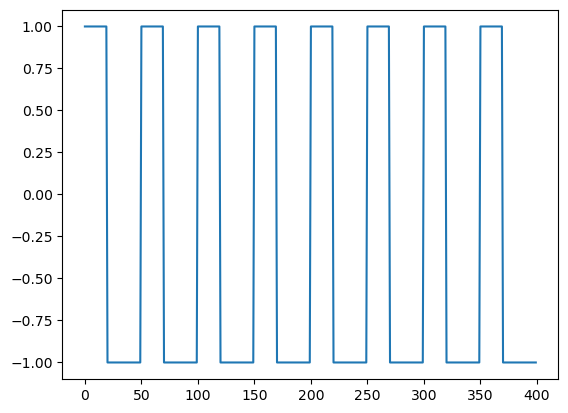

In [4]:
mu = 1
V = np.zeros((Nx)) - mu
V[x % 50 < 20] += 2
plt.plot(x, V)

In [5]:
def make_H(k): 
    H_n = np.zeros((Nx, Nx), dtype=complex)

    H_n += np.diag(np.ones(Nx), 0) * (2 * t)
    H_n += np.diag(np.ones(Nx-1), +1) * (- t)
    H_n += np.diag(np.ones(Nx-1), -1) * (- t)
    H_n[0, -1] = -t * np.exp(- 1j * k * L)
    H_n[-1, 0] = -t * np.exp(+ 1j * k * L)

    H_n += np.diag(V)
    
    return H_n

In [6]:
H_test = make_H(2)
assert(not np.any(H_test - H_test.T.conj()))

In [7]:
k_N = 61
k_ax = np.linspace(-np.pi/L, np.pi/L, k_N)

ws = np.zeros((k_N, Nx))
vs = np.zeros((k_N, Nx, Nx), dtype=complex)

In [8]:
for i, k in enumerate(k_ax):
    ws[i], vs[i] = la.eigh(make_H(k))

(1.0, 5.0)

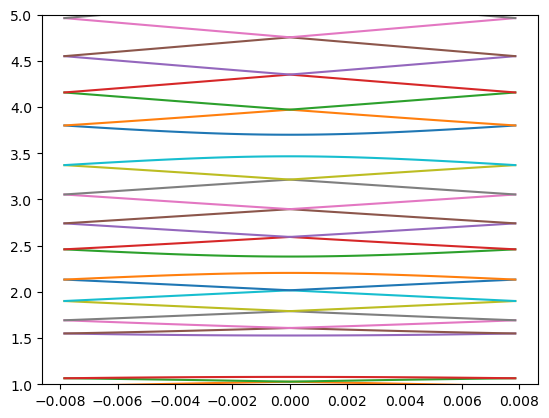

In [9]:
plt.plot(k_ax, ws[:, :]);
plt.ylim(1, 5)

## Superconductivity

In [12]:
L = 200
Delta_0 = 0.5
L_S = 100

In [13]:
Nx = 200
x = np.linspace(0, L, Nx, endpoint=False)
dx = x[1] - x[0]

t = 38 / dx**2

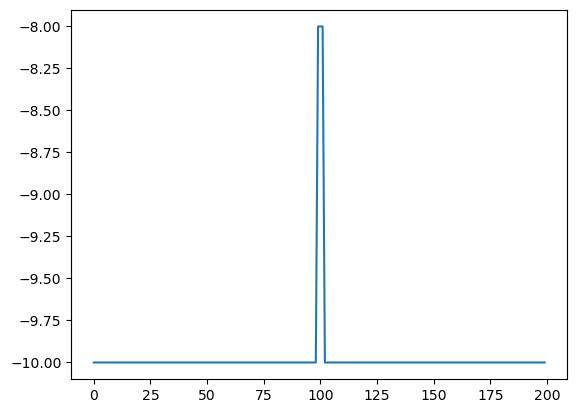

In [14]:
mu = 10
V = np.zeros((Nx)) - mu
V[abs(x-L_S) < 2] += 2
plt.plot(x, V)

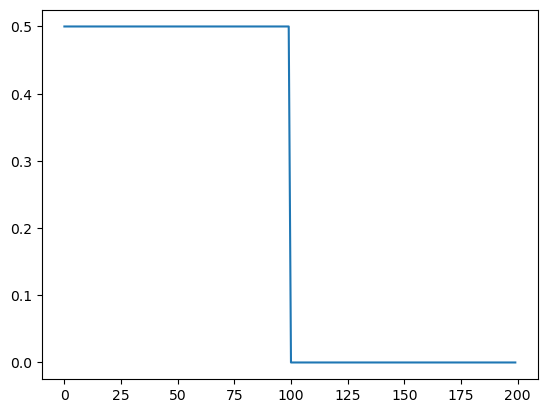

In [15]:
Delta = np.zeros((Nx))
Delta[x < L_S] = Delta_0
plt.plot(x, Delta)

In [16]:
def make_H(k, dphi, Nx, t, V, Delta): 
    H = np.zeros((2 * Nx, 2 * Nx), dtype=complex) 
    
    H_e = np.zeros((Nx, Nx), dtype=complex)
    
    H_e += np.diag(np.ones(Nx), 0) * (2 * t)
    H_e += np.diag(np.ones(Nx-1), +1) * (- t)
    H_e += np.diag(np.ones(Nx-1), -1) * (- t)
    H_e[0, -1] = -t * np.exp(- 1j * k * L - 1j * dphi)
    H_e[-1, 0] = -t * np.exp(+ 1j * k * L + 1j * dphi)
    H_e += np.diag(V)

    H_h = np.zeros((Nx, Nx), dtype=complex)

    H_h += -np.diag(np.ones(Nx), 0) * (2 * t)
    H_h += -np.diag(np.ones(Nx-1), +1) * (- t)
    H_h += -np.diag(np.ones(Nx-1), -1) * (- t)
    H_h[0, -1] = t * np.exp(- 1j * k * L + 1j * dphi)
    H_h[-1, 0] = t * np.exp(+ 1j * k * L - 1j * dphi)
    H_h += -np.diag(V)

    H += np.kron(H_e, [[1, 0], 
                       [0, 0]])
    H += np.kron(H_h, [[0, 0], 
                       [0, 1]])

    H_s = np.diag(Delta)
    H += np.kron(H_s, [[+0, +1], 
                       [+1, +0]])
    
    return H

In [17]:
H_test = make_H(k, 0, Nx, t, V, Delta)
assert(not np.any(H_test - H_test.T.conj()))

In [18]:
H_test[:4, :4]

array([[ 66. +0.j,   0.5+0.j, -38. +0.j,   0. +0.j],
       [  0.5+0.j, -66. +0.j,   0. +0.j,  38. +0.j],
       [-38. +0.j,   0. +0.j,  66. +0.j,   0.5+0.j],
       [  0. +0.j,  38. +0.j,   0.5+0.j, -66. +0.j]])

In [19]:
make_H_bind = partial(make_H, Nx=Nx, t=t, V=V, Delta=Delta)

In [29]:
k_N = 51
k_ax = np.linspace(-np.pi/L, np.pi/L, k_N)

phi_N = 51
phi_ax = np.linspace(0, 2*np.pi, phi_N)

k, phi = np.meshgrid(k_ax, phi_ax)

ws = np.zeros((k_N, phi_N, 2*Nx))
vs = np.zeros((k_N, phi_N, 2*Nx, 2*Nx), dtype=complex)

# nv=20
# ws = np.zeros((k_N, phi_N, nv))
# vs = np.zeros((k_N, phi_N, 2*Nx, nv), dtype=complex)

In [30]:
for i, k in tqdm(enumerate(k_ax), total=k_N):
    for j, phi in enumerate(phi_ax):
        ws[i, j], vs[i, j] = la.eigh(make_H_bind(k, phi))
        # ws[i, j], vs[i, j] = sla.eigsh(make_H_bind(k, phi), k=nv)

  0%|          | 0/51 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\delta \\phi = 3.1415926535897936$')

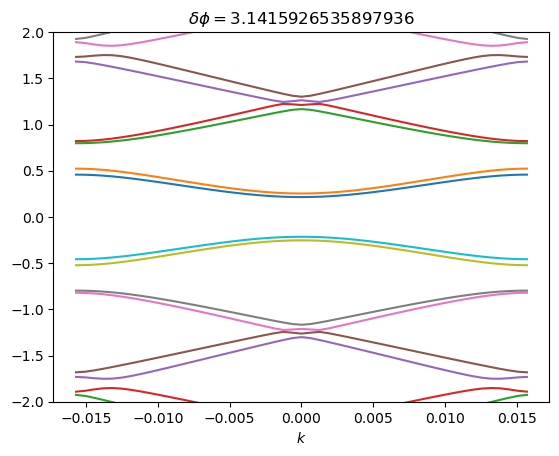

In [31]:
phi_idx = 25

fig, ax = plt.subplots()
ax.plot(k_ax, ws[:, phi_idx]);
ax.set_ylim(-2, 2)
ax.set_xlabel(r"$k$")
ax.set_title(rf"$\delta \phi = {phi_ax[phi_idx]}$")

Text(0.5, 1.0, '$k = 0.0$')

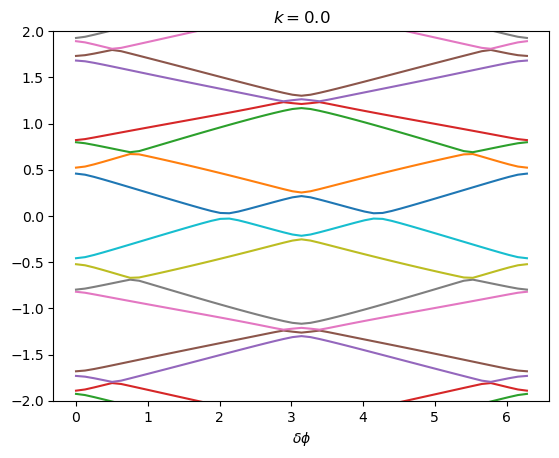

In [32]:
k_idx = 25

fig, ax = plt.subplots()
ax.plot(phi_ax, ws[k_idx, :]);
ax.set_ylim(-2, 2)
ax.set_xlabel(r"$\delta \phi$")
ax.set_title(rf"$k = {k_ax[k_idx]}$")

In [33]:
import numpy as np
from scipy.interpolate import interp1d
from typing import List, Optional, Sequence, Tuple, Union

def thermal_broadening(e_ax: np.ndarray, y: np.ndarray, T: float) -> np.ndarray:
    """
    Computes the thermal broadening of a given spectrum at a given temperature.

    Parameters:
    -----------
    e_ax : np.ndarray
        Array of energy axis values.
    y : np.ndarray
        Array of corresponding values.
    T : float
        Temperature at which to compute the thermal broadening.

    Returns:
    --------
    tb : np.ndarray
        Array of thermal broadening values.

    Raises:
    -------
    AssertionError:
        If the temperature is too low.
    """
    if T < 0.0007:
        return y
    else:
        y_f = interp1d(e_ax, y, bounds_error=False, fill_value="extrapolate")

        def integrand(x: np.ndarray, e: float, T: float) -> np.ndarray:
            return y_f(e - x * T) / (2 * (1 + np.cosh(x)))

        tb: np.ndarray = np.zeros_like(e_ax)

        for i, e in enumerate(e_ax):
            x = np.linspace(e_ax.min() / T, e_ax.max() / T, 4001)
            dx = x[1] - x[0]
            tb[i] = np.sum(integrand(x, e, T)) * dx

        return tb

In [34]:
e_ax = np.linspace(-2, 2, 201)
dos = np.zeros((phi_N, 200))

for j in tqdm(range(phi_N), total=phi_N): 
    for i in range(k_N):
        hist, e = np.histogram(ws[i, j], bins = e_ax)
        dos[j] += thermal_broadening(e[1:], hist, 0.01)

  0%|          | 0/51 [00:00<?, ?it/s]

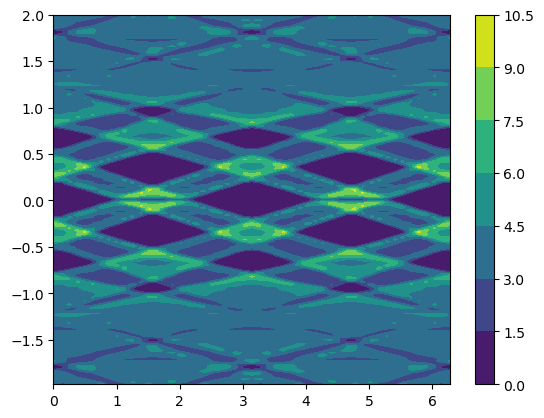

In [35]:
im = plt.contourf( phi_ax, e_ax[1:], dos.T)
plt.colorbar(im)